In [7]:
# libraries for initial data analysis
import os
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Goals
- Create a model that estimates the purchase price of gas at any date in the past and extrapolate it for one year into the future
- Take a date as an input and return a price estimate

# Initial thoughts
- Months of the year for seasonal trends
- What factors cause the price of natural gas to vary?
- Exploratory data analysis
- Try simple regressors first, then more complex techniques


In [8]:
# reading the data
root = os.getcwd()
price_data = pd.read_csv(os.path.join(root, 'Nat_Gas.csv'))

In [9]:
# checking the data
price_data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [10]:
# initial overview of the data
price_data.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [11]:
# Converting the date strings into datetime format
price_data['Dates'] = pd.to_datetime(price_data['Dates'])

C:\Users\johnn\AppData\Local\Temp\ipykernel_2888\1569050736.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  price_data['Dates'] = pd.to_datetime(price_data['Dates'])


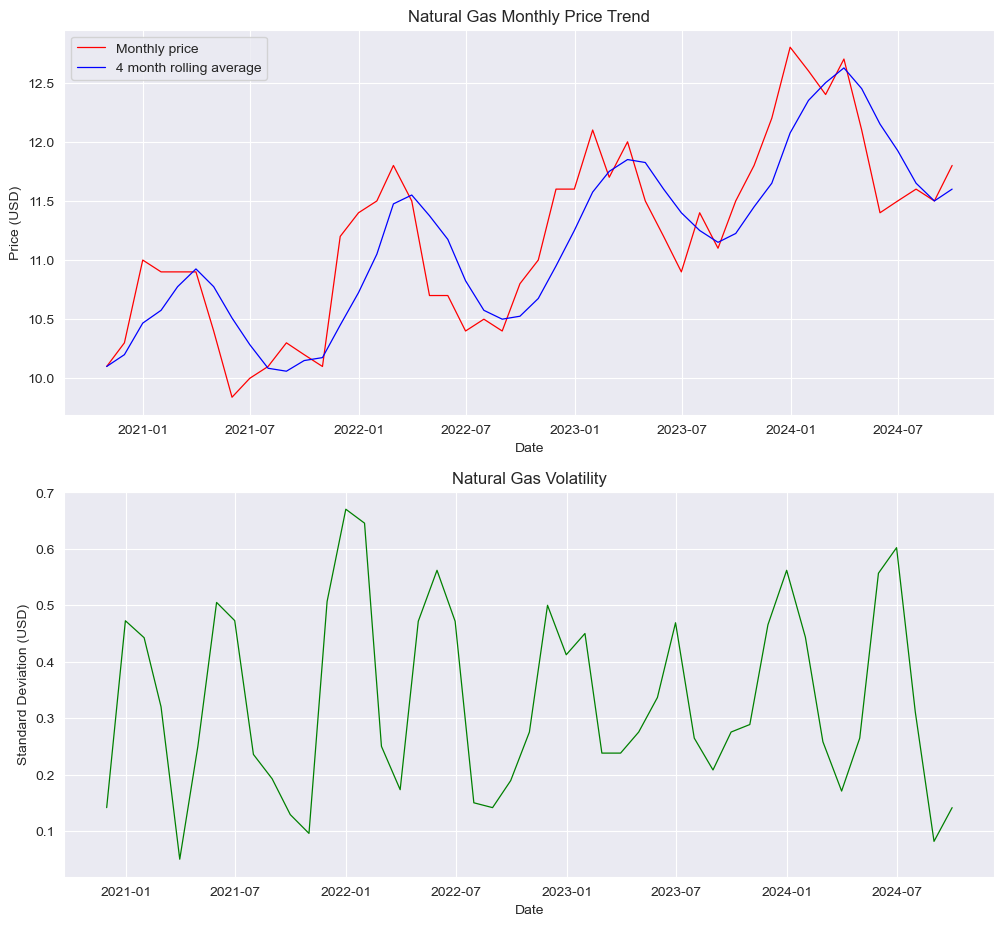

In [90]:
dates = price_data['Dates']
price = price_data['Prices']
window_size = 4  # moving window period in months

# quarterly rolling average
rolling_avg = price.rolling(window_size, min_periods=1).mean()

# quarterly standard deviation
rolling_std_dev = price.rolling(window_size, min_periods=1).std()

# visualisation of the price data
fig, ax1 = plt.subplots(2, 1, figsize=(12, 11))
ax1[0].plot(dates, price, label='Monthly price', color='Red', linewidth=0.9)
ax1[0].plot(dates, rolling_avg, label='4 month rolling average', color='Blue', linewidth=0.9)
ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Price (USD)')
ax1[0].set_title('Natural Gas Monthly Price Trend')
ax1[0].legend()
ax1[0].grid(True)

# Rolling standard deviation to identify volatile periods
ax1[1].plot(dates, rolling_std_dev, label='4 month rolling standard deviation', color='Green', linewidth=0.9)
ax1[1].set_xlabel('Date')
ax1[1].set_ylabel('Standard Deviation (USD)')
ax1[1].set_title('Natural Gas Volatility')
ax1[1].grid(True)


From a first look, there seems to be some seasonality and a clear upwards trend so we will first perform a time series decomposition to quantify seasonality, trend and noise.

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [98]:
# Additive decomposition
decomp_a = seasonal_decompose(price, model='additive', period=6)
trend_a = decomp_a.trend
seasonal_a = decomp_a.seasonal
resid_a = decomp_a.resid

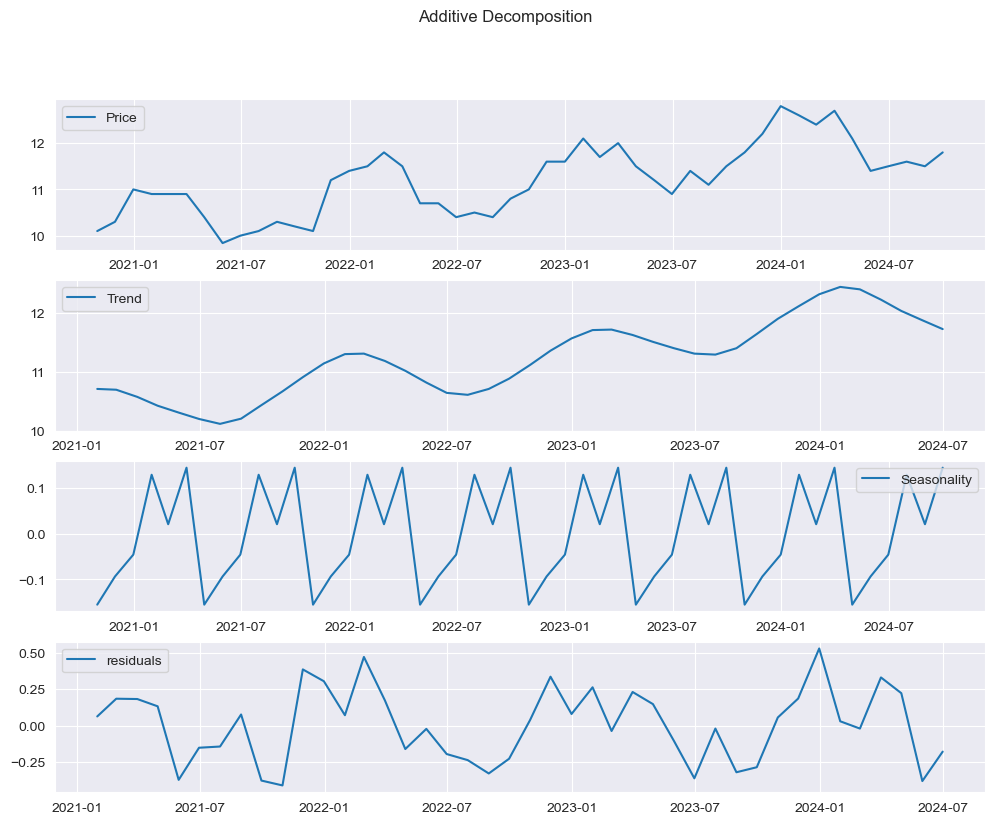

In [99]:
# Plotting the results
plt.figure(figsize=(12,9))
plt.suptitle('Additive Decomposition')


plt.subplot(411)
plt.plot(dates, price, label='Price')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(412)
plt.plot(dates, trend_a, label='Trend')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(413)
plt.plot(dates, seasonal_a, label='Seasonality')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(414)
plt.plot(dates, resid_a, label='residuals')
plt.legend(loc='upper left')
plt.grid(True)

# Predictive models
We will start with basic regressors using the scikit-learn library to learn the trends in the data and create a forecasting model. We need to define features, since the decomposition indicates that:
- there is a linear increase with seasonality, which we can model using SARIMA to start with
- Look for SARIMAX models and possibly include variables like monthly average temperature, since natural gas usage tends to hike up during winter.
We start with this linear model, and then move onto more complex models like XGBoost.


In [227]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [228]:
# automatically creating a SARIMA model
auto_model = auto_arima(price_data['Prices'], seasonal=True, m=6, trace=True, suppress_warnings=True)  # 6 month seasonality


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=48.334, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=48.752, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=51.644, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=46.741, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=49.060, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=49.652, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=50.098, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=50.139, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=51.953, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[6]          
Total fit time: 0.849 seconds


In [229]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -22.370
Date:                Wed, 07 Aug 2024   AIC                             46.741
Time:                        23:57:32   BIC                             48.591
Sample:                             0   HQIC                            47.437
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1517      0.031      4.894      0.000       0.091       0.212
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.62   Prob(JB):                         0.97
Heteroskedasticity (H):               0.92   Skew:                             0.09
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [230]:
# training and test split
x_train, x_test, y_train, y_test = train_test_split(dates, price, test_size=0.3, shuffle=False)

In [232]:
num_periods = 12  # 12 months extrapolation
arima_model = ARIMA(y_train, order=(0, 1, 0))
arima_model = arima_model.fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Prices   No. Observations:                   33
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -15.314
Date:                Wed, 07 Aug 2024   AIC                             32.628
Time:                        23:59:05   BIC                             34.094
Sample:                             0   HQIC                            33.114
                                 - 33                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1525      0.034      4.512      0.000       0.086       0.219
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.57   Prob(JB):                         0.61
Heteroskedasticity (H):               1.26   Skew:                             0.37
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [233]:
arima_model.predict(len(y_train), len(y_train) + num_periods)

33    10.9
34    10.9
35    10.9
36    10.9
37    10.9
38    10.9
39    10.9
40    10.9
41    10.9
42    10.9
43    10.9
44    10.9
45    10.9
Name: predicted_mean, dtype: float64

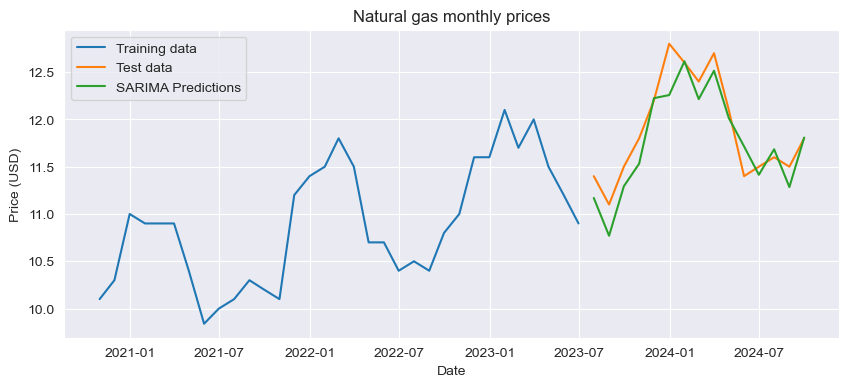

In [218]:
plt.figure(figsize=(10, 4))
plt.plot(x_train, y_train, label='Training data')
plt.plot(x_test, y_test, label='Test data')
plt.plot(x_test, pred, label='SARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title("Natural gas monthly prices")
plt.legend(loc='upper left')

In [184]:
# MAE and R2 score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def evaluate_model(truth, preds, model_type=''):
    mae = mean_absolute_error(truth, preds)
    mse = mean_squared_error(truth, preds)
    r2 = r2_score(truth, preds)
    print(f"Mean Absolute Error of {model_type} model: {mae}")
    print(f"R2 score of {model_type} model: {r2}")
    print(f"Mean Squared Error of {model_type} model: {mse}")
    return None

evaluate_model(y_test, pred, model_type='SARIMA')

Mean Absolute Error of SARIMA model: 0.18543496223597736
R2 score of SARIMA model: 0.8003572119958949
Mean Squared Error of SARIMA model: 0.05389467974830818


In [212]:
# Defining a prediction function which predicts the next 12 months worth of price data

def sarimax_predict(sarimax_model, start_date):
    future_dates = [start_date + relativedelta(months=i) for i in range(15)]   # preparing x_test
    future_prices = pd.Series(sarimax_model.predict(n_periods=len(future_dates), X=future_dates))
    return future_dates, future_prices


Text(0, 0.5, 'Price (USD)')

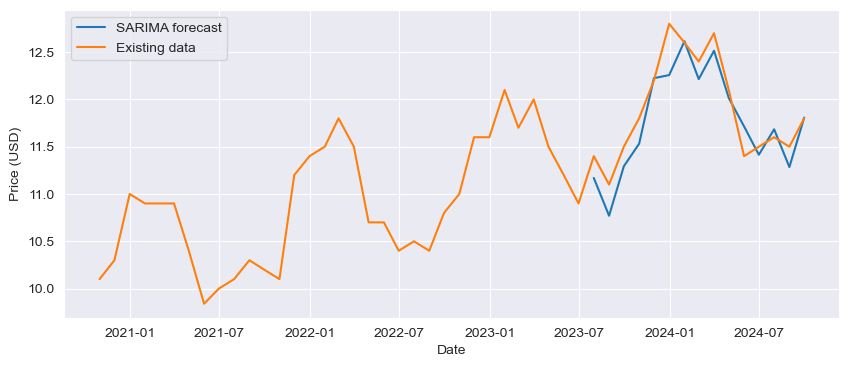

In [215]:
start_date = dates.iloc[33]  # last date in the dataset
yhat_d, yhat_p = sarimax_predict(arima_model, start_date)

plt.figure(figsize=(10, 4))
plt.plot(yhat_d, yhat_p, label='SARIMA forecast')
plt.plot(dates, price, label='Existing data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price (USD)')

These results are okay, but could be improved. We will now try a more complex model like XGBoost to see if we can get better results.

In [22]:
model = sm.tsa.statespace.SARIMAX(price, order=(1, 1, 1), seasonal_order=(1, 1, 1, 6), trend='c')
res = model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 -10.469
Date:                           Wed, 07 Aug 2024   AIC                             32.938
Time:                                   23:03:12   BIC                             43.219
Sample:                                        0   HQIC                            36.682
                                            - 48                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0026      0.010     -0.248      0.804      -0.023       0.018
ar.L1          0.3227      0.244      1.322

In [ ]:
# Forecasting
y_pred = res.predict(start=Len())

In [2]:
import xgboost as xgb

In [312]:
# Train and test splits
x_train, x_test = train_test_split(price_data, test_size=0.2, shuffle=False)

,Dates,Prices
0,2020-10-31,10.10
1,2020-11-30,10.30
2,2020-12-31,11.00
3,2021-01-31,10.90
4,2021-02-28,10.90
5,2021-03-31,10.90
6,2021-04-30,10.40
7,2021-05-31,9.84
8,2021-06-30,10.00
9,2021-07-31,10.10


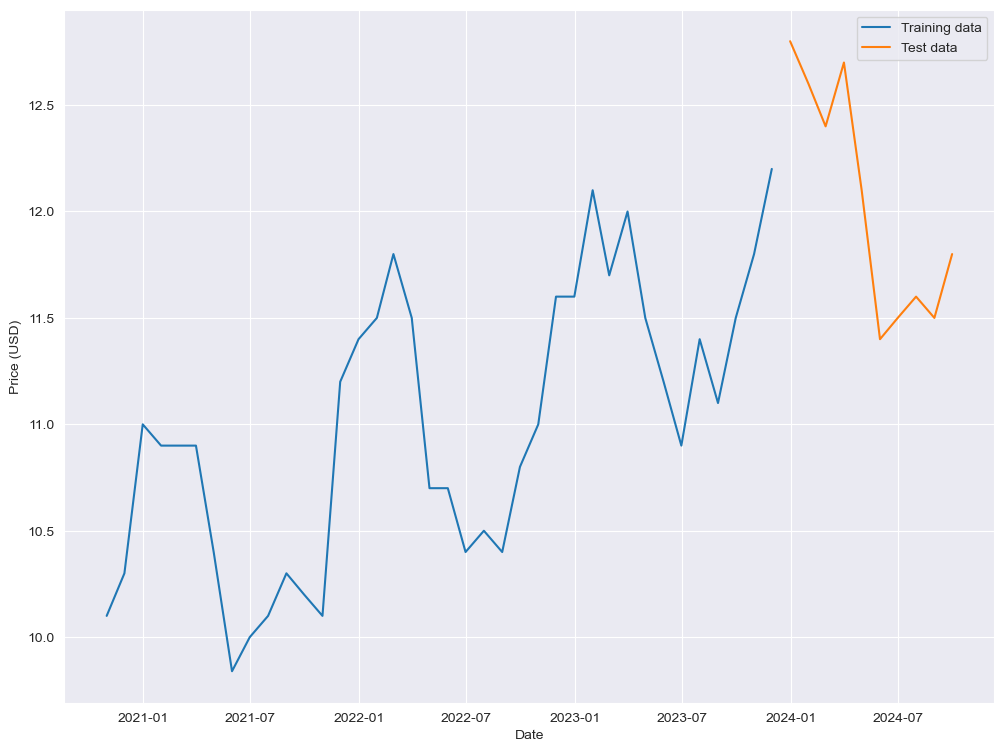

In [313]:
fig3, ax3 = plt.subplots(figsize=(12, 9))
ax3.plot(x_train['Dates'], x_train['Prices'], label='Training data')
ax3.plot(x_test['Dates'], x_test['Prices'], label='Test data')
ax3.set_xlabel('Date')
ax3.set_ylabel('Price (USD)')
ax3.legend()


In [ ]:
# Feature creation
